# Redes Neurais
## 1ª Lista de Exercícios - Classificação de padrões


Aluno:

Base de dados: 

### Para cada item da lista de exercício, não esqueça de fazer uma análise pertinente dos resultados obtidos.

<b> Importante: </b> faça uma média dos resultados para cada item. Como o modelo é estocástico, os resultados podem variar de acordo com a inicialização dos pesos.

In [829]:
import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
from time import sleep

import torch 
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler, Dataset, DataLoader 
import torch.nn.functional as F

from tqdm.notebook import tqdm

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

#Descomentar caso queira utilizar no Google Colab
#from google.colab import drive 
#drive.mount('/content/drive')

In [830]:
class CustomDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)



In [831]:
def plot_confusion_matrix(cm,
                          target_names=None,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if target_names is None:
        target_names = [i for i in range(cm.shape[0])]

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [832]:
def piecewise_norm(vec,val,n):
    '''
    Função para normalização por partes. 
    Argumentos de entrada:
    - vec: vetor com valores de um atributo. 
    - val: valor (na escala original) que deve ocorrer a quebra entre retas.
    - n: valor (normalizado) que deve ocorrer a quebra entre retas.
    '''
    
    assert val > min(vec)
    
    return np.where(vec < val, n*(vec - min(vec))/(val - min(vec)), (1-n)*(vec - val)/(max(vec) - val) + n)

In [833]:
def transform_data(dataset,dataset_columns,normalize=True):
    '''
    Função para transformação de dados para a 1ª Lista de exercícios.
    A transformação possui duas etapas: codificação de variáveis categóricas e normalização de atributos numéricos.
    Parâmetros de entrada:
    - dataset: base de dados a ser ajeitado.
    - dataset_columns: dicionário contendo o nome da coluna e "classe", podendo ser 'numeric', 'categorical' ou 'target'
    - normalize: normalização de atributos utilizando min-max. Default: True.

    A função retorna um dataframe com os atributos categóricos codificados e normalizados (caso normalize = True).
    '''

    new_df = pd.DataFrame()

    #Varre todas as colunas do dataframe.
    for name in dataset.columns:

        #Avalia se a coluna está dentro da lista de colunas com descritores.
        if name in dataset_columns.keys():
            
            #Tratamento de dados utilizando o atributo categórico. No caso, é utilizada a codificação 1 of N.
            if dataset_columns[name] == 'categorical':
                raw_data = dataset[name].values
                d_encoder = LabelEncoder()
                d_encoder.fit(raw_data)
                d_encoded = d_encoder.transform(raw_data)
                #dummy_y = to_categorical(d_encoded)
                dim = len(d_encoder.classes_)
                dummy_y = np.eye(dim)[d_encoded]
                
                for (j,k) in enumerate(d_encoder.classes_):
                    new_df[f'{name}_{k}'] = dummy_y[:,j].astype('int')
            
            
            #Caso numérico, utilizando normalização min-max
            elif dataset_columns[name] == 'numeric':
                raw_data = dataset[name].values
                if normalize:
                    new_df[name] = (raw_data - min(raw_data))/(max(raw_data) - min(raw_data))
                else:
                    new_df[name] = raw_data
                
            #Caso 'original', sem mudança nos valores.
            elif dataset_columns[name] == 'original':
                new_df[name] = dataset[name].values
            
            #Caso target, sem mudança nos valores.
            elif dataset_columns[name] == 'target':
                new_df[name] = dataset[name].values
                
    return new_df

In [834]:
class NeuralNetwork(torch.nn.Module):
  '''
  Objeto criado para facilitar o desenvolvimento dos scripts das aulas práticas.
  Opção alternativa à criação externa fdo modelo. Basicamente serve como um 
  'agregador'  de trechos comuns para a criação do modelo. Por exemplo, ao invés
  de gastar n+1 linhas para a criação de um modelo com n camadas, podemos criar 
  o mesmo modelo com apenas uma linha.
  
  Parâmetros de entrada: 
  - hidden_neurons: Lista com a quantidade de neurônios na camada escondida. 
  - hidden_activation: Função de ativação para cada camada escondida. Aceita 
  como parâmetro string ou lista. Caso o parâmetro receba string, então a mesma
  função de ativação é utilizada para todas as camadas escondidas. Caso seja uma 
  lista, cada camada terá sua propria função de ativação definida pela lista.
  - output_activation: Função de ativação para a camada de saída.
  - lr: Taxa de aprendizado
  - n_input: Tamanho do vetor de entrada.
  - n_output: Saída do modelo.
  '''
  def __init__(self,hidden_neurons = 4, hidden_activation = 'relu', output_activation='softmax', lr = 0.05, n_input = 1, n_output = 1):
    # create model
    super(NeuralNetwork, self).__init__()

    self.activations = {'relu': nn.ReLU(), 'sigmoid':nn.Sigmoid(), 'softmax':nn.Softmax()}

    self.fc1 = nn.Linear(n_input, hidden_neurons)
    self.ha = self.activations[hidden_activation]
    self.fc2 = nn.Linear(hidden_neurons, n_output)
    #self.out = self.activations[output_activation]
    
    #self.out = nn.Sigmoid() #Para o caso binário
  def forward(self,x):
    h = self.fc1(x)
    h1 = self.ha(h) 
    y = self.fc2(h1) 
    #y = self.out(h2)
    return y

  def predict(self, x, binary=True):
    y_hat = self.forward(x)

    if binary:
      y_pred = torch.round(torch.sigmoid(y_hat))
      y_pred = y_pred.detach().numpy()
    else:
      y_pred = torch.argmax(y_hat, dim=1)

    return y_pred




  


In [835]:
def accuracy(y_pred, y_test):
    y_pred_tags = torch.argmax(y_pred, dim=1)
    
    correct_pred = (y_pred_tags == y_test).float().sum()
    acc = correct_pred / y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

#Binary accuracy
def binary_acc(y_pred, y_test):
    y_pred_tags = torch.round(torch.sigmoid(y_pred))

    correct_pred = (y_pred_tags == y_test).float().sum()
    acc = correct_pred/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc


def train(model, train_loader, val_set, epochs, device, lr, binary=True, skip=1):

  if binary:
    criterion = nn.BCEWithLogitsLoss()
  else:
    criterion = nn.CrossEntropyLoss()


  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  history = {'acc_train' : [], 'loss_train': [], 'acc_val': [], 'loss_val': []}

  for e in tqdm(range(1, epochs+1)):
    
    y_hat = np.array([])

    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X, y = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X)
        
        loss = criterion(y_pred, y)
        #acc = accuracy(y_pred, y)
        #Para classificação binária
        if binary:
          acc = binary_acc(y_pred,y)
        else:
          acc = accuracy(y_pred, y)
        
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item()
        train_epoch_acc += acc.item()
        y_p = torch.argmax(y_pred, dim=1)
        y_hat = np.concatenate((y_hat, y_p))
    
    
    model.eval()
    _, val_loss, val_acc = evaluate(model, val_set, criterion, binary=binary)

    history['acc_train'].append(train_epoch_acc/len(train_loader))
    history['loss_train'].append(train_epoch_loss/len(train_loader))
    history['acc_val'].append(val_acc)
    history['loss_val'].append(val_loss)
    
    if e%skip == 0:
      print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.3f} | Val Loss: {val_loss:.4f} | Train Acc: {train_epoch_acc/len(train_loader):.4f}| Val Acc: {val_acc:.4f}')
  return history, y_hat


  

def evaluate(model, val_set, criterion, binary=True):
    X = val_set.X_data
    y = val_set.y_data

    with torch.no_grad():
      y_pred = model(X)
                
    loss = criterion(y_pred, y)
    
    #Para classificação binária
    if binary:
      acc = binary_acc(y_pred, y)
    else:
      acc = accuracy(y_pred, y)

    val_epoch_loss = loss.item()
    val_epoch_acc = acc
    
    return y_pred, val_epoch_loss, val_epoch_acc


In [836]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preparação dos dados

Não esqueça de verificar o path para a pasta. Mude também o filename, de acordo com a base de dados.

In [837]:
#!git clone https://github.com/mdrs-thiago/PUC_Redes_Neurais
#os.chdir('/content/PUC_Redes_Neurais/pos_grad/lista_1')

In [838]:
#Mudar o rootname para o diretório atual do Notebook.
#root_name = '/content/drive/MyDrive/Monitoria_RN/pratica1 - classificacao/'
root_name = os.getcwd()
dataset = 'analise_credito'
filename = os.path.join('datasets',dataset)

In [839]:
description_path = os.path.join(root_name,filename,'data_info.json')
with open(description_path,'r') as f:
    dataset_columns = json.load(f)

In [840]:
dataset_path = os.path.join(root_name, filename,f'class_{dataset}.csv')
dataset = pd.read_csv(dataset_path)

In [841]:
dataset

,ESTC,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,target
0,1,0,360,0,313,9,52,0,25,48,0,1
1,0,0,350,1,468,10,65,0,33,6,0,1
2,0,0,1100,0,829,9,125,0,56,48,0,1
3,0,0,3000,0,552,12,76,1,31,60,0,1
4,1,0,1000,0,809,12,111,0,24,7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1,0,500,0,437,12,60,0,60,48,0,1
1496,1,0,2057,0,301,1,318,0,35,48,0,1
1497,0,0,570,0,511,12,71,1,28,144,0,1
1498,0,0,360,0,384,12,52,0,33,36,0,1


## Parte I - Compreensão do problema e análise de variáveis



### 1)	Observe a base de dados do problema. Existem variáveis que podem ser eliminadas do dataset? Justifique.

#### Rascunho

#### Resposta

### 2)	Implemente técnicas de visualização de dados e seleção de variáveis para extrair características importantes sobre a base de dados. Explique a motivação destas técnicas e o que é possível inferir dos resultados obtidos.

#### Rascunho

#### Resposta

In [842]:
#sns.pairplot(dataset, hue="target", diag_kind="hist")

## 2.	Treinamento do modelo de Rede Neural

### 1)	Com as configurações do modelo MLP previamente definidas no script, faça o treinamento da Rede Neural sem normalizar os atributos numéricos. Comente o resultado obtido, baseado nas métricas de avaliação disponíveis (acurácia, precision, recall, F1-Score, Matriz de confusão, etc.)

#### Rascunho

In [843]:
new_df = transform_data(dataset,dataset_columns,normalize=False)
#new_df.head()

In [844]:
new_df.head()

,ESTC_0,ESTC_1,ESTC_2,ESTC_3,NDEP,RENDA,TIPOR_0,TIPOR_1,VBEM,NPARC,VPARC,TEL_0,TEL_1,IDADE,RESMS,ENTRADA,target
0,0,1,0,0,0,360,1,0,313,9,52,1,0,25,48,0,1
1,1,0,0,0,0,350,0,1,468,10,65,1,0,33,6,0,1
2,1,0,0,0,0,1100,1,0,829,9,125,1,0,56,48,0,1
3,1,0,0,0,0,3000,1,0,552,12,76,0,1,31,60,0,1
4,0,1,0,0,0,1000,1,0,809,12,111,1,0,24,7,0,1


In [845]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1
  binary = True
else:
  print('Multiclass classification')
  n_output = len(encoder.classes_)
  binary = False
  #y = np.eye(n_output)[y]

Binary classification


In [846]:
batch_size = 32 
epochs = 170

In [847]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [848]:

#Para o caso de múltiplas classes
#train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
#val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
#test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())



In [849]:
#Para o caso binário
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [850]:
train_dataset.X_data

tensor([[  0.,   1.,   0.,  ...,  58.,   6.,   0.],
        [  1.,   0.,   0.,  ...,  40.,   6.,   0.],
        [  1.,   0.,   0.,  ...,  27.,   6.,   0.],
        ...,
        [  1.,   0.,   0.,  ...,  63.,   0., 285.],
        [  0.,   1.,   0.,  ...,  20.,  48.,   0.],
        [  1.,   0.,   0.,  ...,  36.,   6.,   0.]])

In [851]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')

In [852]:
lr = 0.01
epochs = 250

history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)

Epoch 001: | Train Loss: 0.878 | Val Loss: 0.7187 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 002: | Train Loss: 0.724 | Val Loss: 0.7147 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 003: | Train Loss: 0.719 | Val Loss: 0.7112 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 004: | Train Loss: 0.716 | Val Loss: 0.7083 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 005: | Train Loss: 0.712 | Val Loss: 0.7058 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 006: | Train Loss: 0.710 | Val Loss: 0.7037 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 007: | Train Loss: 0.707 | Val Loss: 0.7019 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 008: | Train Loss: 0.705 | Val Loss: 0.7004 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 009: | Train Loss: 0.703 | Val Loss: 0.6991 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 010: | Train Loss: 0.702 | Val Loss: 0.6980 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 011: | Train Loss: 0.701 | Val Loss: 0.6971 | Train Acc: 47.9333| Val Acc: 50.0000
Epoch 012: | Train Lo

In [853]:
y_pred = model.predict(test_dataset.X_data, binary=binary)

              precision    recall  f1-score   support

           0       0.55      1.00      0.71       164
           1       0.00      0.00      0.00       136

    accuracy                           0.55       300
   macro avg       0.27      0.50      0.35       300
weighted avg       0.30      0.55      0.39       300



C:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python38\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


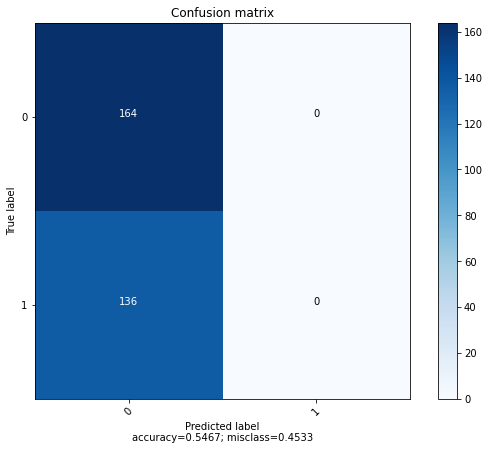

In [854]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

#### Resposta

### 2)	Agora normalize os dados de entrada e treine novamente o modelo MLP. Avalie os resultados obtidos e comente o efeito da normalização no treinamento da Rede Neural.

#### Rascunho

In [855]:
new_df = transform_data(dataset,dataset_columns,normalize=True)
new_df.head()

,ESTC_0,ESTC_1,ESTC_2,ESTC_3,NDEP,RENDA,TIPOR_0,TIPOR_1,VBEM,NPARC,VPARC,TEL_0,TEL_1,IDADE,RESMS,ENTRADA,target
0,0,1,0,0,0.0,0.007792,1,0,0.003514,0.347826,0.003026,1,0,0.117647,0.114286,0.0,1
1,1,0,0,0,0.0,0.006494,0,1,0.045405,0.391304,0.022693,1,0,0.274510,0.014286,0.0,1
2,1,0,0,0,0.0,0.103896,1,0,0.142973,0.347826,0.113464,1,0,0.725490,0.114286,0.0,1
3,1,0,0,0,0.0,0.350649,1,0,0.068108,0.478261,0.039334,0,1,0.235294,0.142857,0.0,1
4,0,1,0,0,0.0,0.090909,1,0,0.137568,0.478261,0.092284,1,0,0.098039,0.016667,0.0,1


In [856]:
X = new_df.values[:,:-1].astype('float')
target = new_df.values[:,-1]

encoder = LabelEncoder()
y = encoder.fit_transform(target)

n_input = X.shape[1]

if np.unique(y).shape[0] <= 2:
  print('Binary classification')
  n_output = 1

else:
  print('Multiclass classification')
  #y = to_categorical(y)
  n_output = encoder.classes_.shape[0]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

Binary classification


In [857]:
if binary:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float().unsqueeze(1))
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float().unsqueeze(1))
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float().unsqueeze(1))
else:
    train_dataset = CustomDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
    val_dataset = CustomDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
    test_dataset = CustomDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

train_loader = DataLoader(dataset=train_dataset,batch_size=batch_size)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [858]:
model = NeuralNetwork(n_input = n_input, n_output=n_output,output_activation='sigmoid')
history, y_hat = train(model, train_loader, val_dataset, epochs=epochs, lr=lr, device=device, binary=binary)

Epoch 500: | Train Loss: 0.301 | Val Loss: 0.3244 | Train Acc: 90.1000| Val Acc: 90.0000
Epoch 1000: | Train Loss: 0.291 | Val Loss: 0.3159 | Train Acc: 90.0667| Val Acc: 90.0000
Epoch 1500: | Train Loss: 0.284 | Val Loss: 0.3132 | Train Acc: 90.2333| Val Acc: 89.0000
Epoch 2000: | Train Loss: 0.279 | Val Loss: 0.3120 | Train Acc: 90.4333| Val Acc: 89.0000
Epoch 2500: | Train Loss: 0.276 | Val Loss: 0.3123 | Train Acc: 90.6333| Val Acc: 89.0000
Epoch 3000: | Train Loss: 0.274 | Val Loss: 0.3137 | Train Acc: 90.5333| Val Acc: 89.0000
Epoch 3500: | Train Loss: 0.273 | Val Loss: 0.3148 | Train Acc: 90.4667| Val Acc: 88.0000
Epoch 4000: | Train Loss: 0.272 | Val Loss: 0.3159 | Train Acc: 90.4667| Val Acc: 88.0000
Epoch 4500: | Train Loss: 0.271 | Val Loss: 0.3168 | Train Acc: 90.4667| Val Acc: 88.0000
Epoch 5000: | Train Loss: 0.271 | Val Loss: 0.3177 | Train Acc: 90.4667| Val Acc: 88.0000



#### Resposta

In [859]:
y_pred = model.predict(test_dataset.X_data,binary=binary)


              precision    recall  f1-score   support

           0       0.84      0.96      0.89       164
           1       0.94      0.78      0.85       136

    accuracy                           0.88       300
   macro avg       0.89      0.87      0.87       300
weighted avg       0.88      0.88      0.88       300



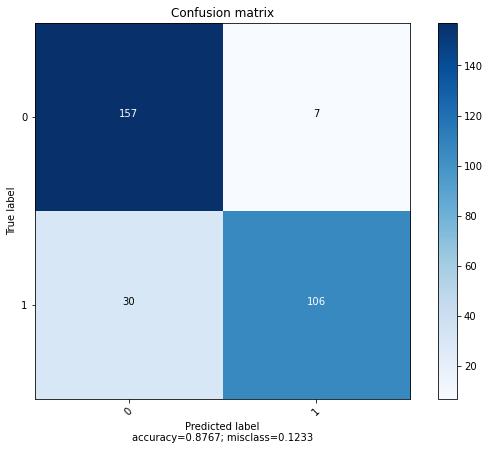

In [860]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm)

## Parte III - Mudança de configurações do modelo

### 1)	Implemente a técnica de parada antecipada (Early Stopping) usando o conjunto de validação. Avalie o resultado obtido.

OBS: crie uma nova função (e.g. train_EarlyStopping) ou use um parâmetro para habilitar/desabilitar o Early Stopping.

#### Rascunho

#### Resposta

### 2)	Modifique o tempo de treinamento (épocas) da Rede Neural. Escolha valores distintos (e.g. 1 e 1000 épocas) e avalie os resultados.
OBS: Não use Early Stopping neste item.

#### Rascunho

#### Resposta

### 3)	 Modifique a taxa de aprendizado da Rede Neural. Escolha valores distintos (e.g. 0,001 e 0,1) e avalie os resultados.
OBS: Não use Early Stopping neste item.

#### Rascunho

#### Resposta

### 4)	Modifique a quantidade de neurônios na camada escondida da Rede Neural. Escolha valores distintos (e.g. 2 e 70 neurônios) e avalie os resultados.
OBS: Não use Early Stopping neste item.

#### Rascunho

#### Resposta

## Parte IV - Análise dos resultados

### 1)	Faça novos testes para avaliar o desempenho da Rede Neural no problema designado usando a técnica K-Fold (com K = 10). Comente o resultado obtido.

Dica: não é necessário utilizar a ferramenta KFold do scikit-learn para o desenvolvimento deste item. Uma alternativa <b> simples </b> é fazer um *for loop*, selecionando os índices em bloco. 

#### Rascunho

#### Resposta

### 2)	Faça análises e novas implementações que você julgue importante para o seu trabalho. Não esqueça de explicar a motivação da análise realizada. 

#### Rascunho

#### Resposta